In [ ]:
#  #########################################################################
#  #                           IN THE NAME OF ALLAH                        #
#  #  STEEL PLATE THICKNESS OPTIMIZATION ANALYSIS WITH NONLINEAR DYNAMIC   #
#  #                         NEWTON-RAPHSON METHOD                         #
#  #-----------------------------------------------------------------------#
#  #              THIS PROGRAM WRITTEN BY SALAR DELAVAR QASHQAI            #
#  #                   EMAIL: salar.d.ghashghaei@gmail.com                 #
#  #########################################################################

In [2]:
#import the os module
import os
import math
import time

In [3]:
#to create a directory at specified path with name "Data"
os.mkdir('C:\\OPENSEESPY_SALAR')
#this will create the directory with name 'Data' and will update it when we rerun the analysis,
# otherwise we have to keep deleting the old 'Data' Folder
dir = "C:\\OPENSEESPY_SALAR\\OPENSEESPY_DATA"
if not os.path.exists(dir):
    os.makedirs(dir)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:\\OPENSEESPY_SALAR'

In [4]:
# Your existing code
def MAXABS_FUN(DATA_FILE):
    import numpy as np
    # Read and process displacement data
    NameFiles = DATA_FILE
    filename = f"{NameFiles}.txt"
    D = np.loadtxt(filename)
    #print(D)
    MAXABS = np.max(np.abs([D[:, 1]]))
    #print("MAX. ABS. :", MAXABS)
    return MAXABS

In [5]:
# pip install openseespy

In [6]:
# OUTPUT DATA ADDRESS:
SALAR_DIR = 'C:/OPENSEESPY_SALAR/OPENSEESPY_DATA/';

In [7]:
#
#    ^Y
#    |
#    2       __ 
#    |          | 
#    |          |
#    |          |
#  (1)       LCol
#    |          |
#    |          |
#    |          |
#  =1=      _|_  -------->X
#

# SET UP ----------------------------------------------------------------------------


#########################################################################################################################################################################

def DYNAMIC_ANALYSIS(LR, TR, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc):
    import openseespy.opensees as op
    op.wipe()
    op.model('basic', '-ndm', 2, '-ndf', 3) 
    PCol =Weight  # nodal dead-load weight per column
    g =  9810 # mm/s^2
    Mass =  PCol/g

    #ACol = BCol*HCol;  # cross-sectional area, make stiff
    IzCol = (BCol* HCol**3)/12; # Column moment of inertia
    L = LCol - LR; # NOT Retrofitrd Length
    # nodal coordinates:
    op.node(1, 0.0, 0.0) # node#, X, Y
    op.node(2, 0.0, LR)
    op.node(3, 0.0, LCol)
    # Single point constraints -- Boundary Conditions
    op.fix(1, 1, 1, 1) # node DX DY RZ
    # node#, Mx My Mz, Mass=Weight/g, neglect rotational inertia at nodes
    op.mass(2, Mass, 1e-9, 0.0)
    
    barAreaCol = (3.1415 * BD**2) / 4  # area of longitudinal-reinforcement bars
    
    ColSecTag01 = 1			# Retrofited Section - assign a tag number to the column section
    ColSecTag02 = 2			# Not Retrofited Section - assign a tag number to the column section
    # MATERIAL parameters -------------------------------------------------------------------
    IDconcCore = 1; 				# material ID tag -- confined core concrete
    IDconcCover = 2; 				# material ID tag -- unconfined cover concrete
    IDreinf = 3; 				# material ID tag -- reinforcement
    IDrp = 4; 				# material ID tag -- retofited plate 
    
    # nominal concrete compressive strength
    Ec = 4700 * math.sqrt(-fc) # Concrete Elastic Modulus (the term in sqr root needs to be in psi

    # confined concrete
    Kfc = 1.3;			# ratio of confined to unconfined concrete strength
    fc1C = Kfc*fc;		# CONFINED concrete (mander model), maximum stress
    eps1C = 2*fc1C/Ec;	# strain at maximum stress 
    fc2C = 0.2*fc1C;		# ultimate stress
    eps2C = 5*eps1C;		# strain at ultimate stress 
    # unconfined concrete
    fc1U = fc;			# UNCONFINED concrete (todeschini parabolic model), maximum stress
    eps1U = -0.0025;			# strain at maximum strength of unconfined concrete
    fc2U = 0.2*fc1U;		# ultimate stress
    eps2U = -0.012;			# strain at ultimate stress
    Lambda = 0.1;				# ratio between unloading slope at $eps2 and initial slope $Ec
    # tensile-strength properties
    ftC = -0.55*fc1C;		# tensile strength +tension
    ftU = -0.55*fc1U;		# tensile strength +tension
    Ets = ftU/0.002;		# tension softening stiffness
    # REBAR MATERIAL PROPERTIES:
    Fy = 4000			# Steel rebar yield stress
    Cy = 0.02			# Steel rebar yield strain
    Es = Fy/Cy				# modulus of steel
    Bs = 0.01				# strain-hardening ratio 
    R0 = 18.0				# control the transition from elastic to plastic branches
    cR1 = 0.925				# control the transition from elastic to plastic branches
    cR2 = 0.15				# control the transition from elastic to plastic branches
    # PLATE MATERIAL PROPERTIES:
    FyP = 2400			# Steel plate yield stress
    CyP = 0.02			# Steel plate yield strain
    Es = FyP/CyP				# modulus of steel
    Bs = 0.01				# strain-hardening ratio 
    R0 = 18.0				# control the transition from elastic to plastic branches
    cR1 = 0.925				# control the transition from elastic to plastic branches
    cR2 = 0.15				# control the transition from elastic to plastic branches

    op.uniaxialMaterial('Concrete02', IDconcCore, fc1C, eps1C, fc2C, eps2C, Lambda, ftC, Ets) # build cover concrete (confined)
    op.uniaxialMaterial('Concrete02', IDconcCover, fc1U, eps1U, fc2U, eps2U, Lambda, ftU, Ets) # build cover concrete (unconfined)
    op.uniaxialMaterial('Steel02', IDreinf, Fy, Es, Bs, R0,cR1,cR2) # build reinforcement material
    op.uniaxialMaterial('Steel02', IDrp, FyP, Es, Bs, R0,cR1,cR2) # build retrofited plate material
    # FIBER SECTION properties -------------------------------------------------------------
    # symmetric section
    #                        y
    #                        ^
    #                        |     
    #             ---------------------     --   --
    #             |   o  o   o   o    |     |    -- cover
    #             |                   |     |
    #             |   o           o   |     |
    #    z <---   |          +        |     H
    #             |   o           o   |     |
    #             |                   |     |
    #             |   o  o    o   o   |     |    -- cover
    #             ---------------------     --   --
    #             |-------- B --------|
    #
    # RC section: 

    coverY = (HCol+TR) / 2.0	# The distance from the section z-axis to the edge of the cover concrete -- outer edge of cover concrete
    coverZ = (BCol+TR) / 2.0	# The distance from the section y-axis to the edge of the cover concrete -- outer edge of cover concrete
    
    plateY = coverY - TR
    plateZ = coverZ - TR
    coreY = coverY - coverCol - TR
    coreZ = coverZ - coverCol - TR
    coreY02 = coreY - 50 # Middle Rebar Distance
    coreZ02 = coreZ      # Middle Rebar Distance
    
    #MID_numBarsCol = numBarsCol/2
    nfPlateY = 16;			# number of fibers for concrete in y-direction -- plate steel
    nfPlateZ = 4;			# number of fibers for concrete in z-direction
    nfCoreY = 16;			# number of fibers for concrete in y-direction -- core concrete
    nfCoreZ = 4;			# number of fibers for concrete in z-direction
    nfCoverY = 16;			# number of fibers for concrete in y-direction -- cover concrete
    nfCoverZ = 4;			# number of fibers for concrete in z-direction
    # -----------------------------------------------------------------------------------------------------
    # RETROFITED SECTION: 
    op.section('Fiber', ColSecTag01)
    # Define the four plate patches
    op.patch('quad', IDrp, nfPlateZ, nfPlateY, -coverY, coverZ, -plateY, plateZ, plateY, plateZ, coverY, coverZ) # Define the plate patch
    op.patch('quad', IDrp, nfPlateZ, nfPlateY, -plateY, -plateZ, -coverY, -coverZ, coverY, -coverZ, plateY, -plateZ) # Define the plate patch
    op.patch('quad', IDrp, nfPlateZ, nfPlateY, -coverY, coverZ, -coverY, -coverZ, -plateY, -plateZ, -plateY, plateZ) # Define the plate patch
    op.patch('quad', IDrp, nfPlateZ, nfPlateY, plateY, plateZ, plateY, -plateZ, coverY, -coverZ, coverY, coverZ) # Define the plate patch
    # Define the core patch
    op.patch('quad', IDconcCore, nfCoreZ, nfCoreY, -coreY,coreZ, -coreY,-coreZ, coreY,-coreZ, coreY, coreZ) # Define the concrete patch
    # Define the four cover patches
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, -coverY, coverZ, -coreY, coreZ, coreY, coreZ, coverY, coverZ) # Define the concrete patch
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, -coreY, -coreZ, -coverY, -coverZ, coverY, -coverZ, coreY, -coreZ) # Define the concrete patch
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, -coverY, coverZ, -coverY, -coverZ, -coreY, -coreZ, -coreY, coreZ) # Define the concrete patch
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, coreY, coreZ, coreY, -coreZ, coverY, -coverZ, coverY, coverZ) # Define the concrete patch
    # Define reinfocement layers    
    op.layer('straight', IDreinf, numBarsCol, barAreaCol, coreY, coreZ, coreY, -coreZ)# top layer reinforcement
    op.layer('straight', IDreinf, 2, barAreaCol, coreY02, coreZ02, coreY02, -coreZ02)# middle top layer reinforcement
    op.layer('straight', IDreinf, 2, barAreaCol, -coreY02, coreZ02, -coreY02, -coreZ02)# middle bottom layer reinforcement
    op.layer('straight', IDreinf, numBarsCol, barAreaCol, -coreY, coreZ, -coreY, -coreZ)# bottom layer reinfocement
    
    ColTransfTag01 = 1
    op.geomTransf('Linear', ColTransfTag01)
    numIntgrPts = 5
    eleTag = 1
    op.element('nonlinearBeamColumn', eleTag, 1, 2, numIntgrPts, ColSecTag01, ColTransfTag01)
    # -----------------------------------------------------------------------------------------------------
    # NOT RETROFITED SECTION:
    op.section('Fiber', ColSecTag02)
    # Define the core patch
    op.patch('quad', IDconcCore, nfCoreZ, nfCoreY, -coreY, coreZ, -coreY,-coreZ, coreY,-coreZ, coreY, coreZ) # Define the concrete patch
    # Define the four cover patches
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, -coverY,coverZ, -coreY, coreZ, coreY, coreZ, coverY,coverZ) # Define the concrete patch
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, -coreY, -coreZ, -coverY, -coverZ, coverY, -coverZ, coreY, -coreZ) # Define the concrete patch
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, -coverY, coverZ, -coverY, -coverZ, -coreY, -coreZ, -coreY, coreZ) # Define the concrete patch
    op.patch('quad', IDconcCover, nfCoverZ, nfCoverY, coreY, coreZ, coreY, -coreZ, coverY,-coverZ, coverY,coverZ) # Define the concrete patch
    # Define reinfocement layers    
    op.layer('straight', IDreinf, numBarsCol, barAreaCol, coreY, coreZ, coreY, -coreZ)# top layer reinforcement
    op.layer('straight', IDreinf, 2, barAreaCol, coreY02, coreZ02, coreY02, -coreZ02)# middle top layer reinforcement
    op.layer('straight', IDreinf, 2, barAreaCol, -coreY02, coreZ02, -coreY02, -coreZ02)# middle bottom layer reinforcement
    op.layer('straight', IDreinf, numBarsCol, barAreaCol, -coreY, coreZ, -coreY, -coreZ)# bottom layer reinfocement
    
    ColTransfTag02 = 2
    op.geomTransf('Linear', ColTransfTag02)
    numIntgrPts = 5
    eleTag = 2
    op.element('nonlinearBeamColumn', eleTag, 2, 3, numIntgrPts, ColSecTag02, ColTransfTag02)
    # -----------------------------------------------------------------------------------------------------

    #import InelasticFiberSection
    op.recorder('EnvelopeNode','-file', f"{SALAR_DIR}MD.txt" ,'-time','-node',2,'-dof',1,'disp');# max. displacements of free nodes 2
    op.recorder('EnvelopeNode','-file', f"{SALAR_DIR}MD02.txt" ,'-time','-node',3,'-dof',1,'disp');# max. displacements of free nodes 3
    op.recorder('EnvelopeNode','-file',f"{SALAR_DIR}MV.txt" ,'-time','-node',3,'-dof',1,'disp');# max. vel of free nodes 3
    op.recorder('EnvelopeNode','-file', f"{SALAR_DIR}MA.txt" ,'-time','-node',3,'-dof',1,'disp');# max. accel of free nodes 3	
    op.recorder('Node', '-file', f"{SALAR_DIR}DTH.txt",'-time', '-node', 2, '-dof', 1,2,3, 'disp')# Displacement Time History
    op.recorder('Node', '-file', f"{SALAR_DIR}VTH.txt",'-time', '-node', 2, '-dof', 1,2,3, 'vel')# Vel Time History
    op.recorder('Node', '-file', f"{SALAR_DIR}ATH.txt",'-time', '-node', 2, '-dof', 1,2,3, 'accel')# Accel Time History
    op.recorder('Node', '-file', f"{SALAR_DIR}BTH.txt",'-time', '-node', 1, '-dof', 1,2,3, 'reaction')# Base Shear Time History
    op.recorder('Element', '-file', f"{SALAR_DIR}FCol.txt",'-time', '-ele', 1, 'globalForce')
    op.recorder('Element', '-file', f"{SALAR_DIR}ForceColSec1.txt",'-time', '-ele', 1, 'section', 1, 'force')
    op.recorder('Element', '-file', f"{SALAR_DIR}DCol.txt','-time", '-ele', 1, 'deformations')

    #defining gravity loads
    op.timeSeries('Linear', 1)
    op.pattern('Plain', 1, 1)
    op.load(2, 0.0, -PCol, 0.0)

    Tol = 1e-8 # convergence tolerance for test
    NstepGravity = 10
    DGravity = 1/NstepGravity
    op.integrator('LoadControl', DGravity) # determine the next time step for an analysis
    op.numberer('Plain') # renumber dof's to minimize band-width (optimization), if you want to
    op.system('BandGeneral') # how to store and solve the system of equations in the analysis
    op.constraints('Plain') # how it handles boundary conditions
    op.test('NormDispIncr', Tol, 6) # determine if convergence has been achieved at the end of an iteration step
    op.algorithm('Newton') # use Newton's solution algorithm: updates tangent stiffness at every iteration
    op.analysis('Static') # define type of analysis static or transient
    op.analyze(NstepGravity) # apply gravity

    op.loadConst('-time', 0.0) #maintain constant gravity loads and reset time to zero

    #applying Dynamic Ground motion analysis
    GMdirection = 1
    GMfile = 'BM68elc.acc'
    GMfact = 1.0



    Lambda01 = op.eigen('-fullGenLapack', 1) # eigenvalue mode 1
    Lambda02 = op.eigen('-genBandArpack', 1) # eigenvalue mode 1
    #print(Lambda)
    Omega = math.pow(max(min(Lambda01), min(Lambda02)), 0.5)
    betaKcomm = 2 * (0.02/Omega)

    xDamp = 0.02				# 2% damping ratio
    alphaM = 0.0				# M-prop. damping; D = alphaM*M	
    betaKcurr = 0.0		# K-proportional damping;      +beatKcurr*KCurrent
    betaKinit = 0.0 # initial-stiffness proportional damping      +beatKinit*Kini

    op.rayleigh(alphaM,betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping

    # Uniform EXCITATION: acceleration input
    IDloadTag = 400			# load tag
    dt = 0.01			# time step for input ground motion
    GMfatt = 1.0			# data in input file is in g Unifts -- ACCELERATION TH
    maxNumIter = 10
    op.timeSeries('Path', 2, '-dt', dt, '-filePath', GMfile, '-factor', GMfact)
    op.pattern('UniformExcitation', IDloadTag, GMdirection, '-accel', 2) 

    op.wipeAnalysis()
    op.constraints('Transformation')
    op.numberer('Plain')
    op.system('BandGeneral')
    op.test('EnergyIncr', Tol, maxNumIter)
    op.algorithm('ModifiedNewton')

    NewmarkGamma = 0.5
    NewmarkBeta = 0.25
    op.integrator('Newmark', NewmarkGamma, NewmarkBeta)
    op.analysis('Transient')

    DtAnalysis = 0.01
    TmaxAnalysis = 10.0

    Nsteps =  int(TmaxAnalysis/ DtAnalysis)

    ok = op.analyze(Nsteps, DtAnalysis)

    tCurrent = op.getTime()

    # for gravity analysis, load control is fine, 0.1 is the load factor increment (http://opensees.berkeley.edu/wiki/index.php/Load_Control)

    test = {1:'NormDispIncr', 2: 'RelativeEnergyIncr', 4: 'RelativeNormUnbalance',5: 'RelativeNormDispIncr', 6: 'NormUnbalance'}
    algorithm = {1:'KrylovNewton', 2: 'SecantNewton' , 4: 'RaphsonNewton',5: 'PeriodicNewton', 6: 'BFGS', 7: 'Broyden', 8: 'NewtonLineSearch'}

    for i in test:
        for j in algorithm:

            if ok != 0:
                if j < 4:
                    op.algorithm(algorithm[j], '-initial')

                else:
                    op.algorithm(algorithm[j])

                op.test(test[i], Tol, 1000)
                ok = op.analyze(Nsteps, DtAnalysis)                            
                print(test[i], algorithm[j], ok)             
                if ok == 0:
                    break
            else:
                continue

    #u2 = op.nodeDisp(2, 1)
    #print("u2 = ", u2)
    print('Ground Motion Done.')
    op.wipe()
    


In [8]:
def HISROGRAM_BOXPLOT(X, HISTO_COLOR, LABEL):
    import numpy as np
    import matplotlib.pyplot as plt
    X = np.array(X)
    print("-------------------------")
    from scipy.stats import skew, kurtosis
    MINIMUM = np.min(X)
    MAXIMUM = np.max(X)
    #MODE = max(set(X), key=list(X).count)
    MEDIAN = np.quantile(X, .50)#q2
    MEAN = np.mean(X)
    STD = np.std(X)
    q1 = np.quantile(X, .25)
    q3 = np.quantile(X, .75)
    SKEW = skew(X)
    KURT = kurtosis(X)
    #SKEW = (MEAN - MODE) / STD
    #KURT = (np.mean((X - MEAN)**4) / STD**4)
    # Estimate confidence intervals of the output variable
    lower_bound = np.quantile(X, .05)
    upper_bound = np.quantile(X, .95)
    print("Box-Chart Datas: ")
    print(f'Minimum: {MINIMUM:.4f}')
    print(f'First quartile: {q1:.4f}')
    #print(f'Mode: {MODE:.4f}')
    print(f'Median: {MEDIAN:.4f}')
    print(f'Mean: {MEAN:.4f}')
    print(f'Std: {STD:.4f}')
    print(f'Third quartile: {q3:.4f}')
    print(f'Maximum: {MAXIMUM :.4f}')
    print(f'Skewness: {skew(X) :.4f}')
    print(f'kurtosis: {kurtosis(X) :.4f}')
    print(f"90% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")
    print("-------------------------")

    plt.figure(figsize=(10,6))
    # Plot histogram of data
    count, bins, ignored = plt.hist(X, bins=100, color=HISTO_COLOR, density=True, align='mid')#, edgecolor="black"
    
    # Plot lognormal PDF
    x = np.linspace(min(bins), max(bins), 10000)
    pdf = (np.exp(-(x - MEAN)**2 / (2 * STD**2)) / (STD * np.sqrt(2 * np.pi)))
    plt.plot(x, pdf, linewidth=2, color='r', label="Normal PDF")
    
    # Plot vertical lines for risk measures
    plt.axvline(q1, color="black", linestyle="--", label=f"Quantile 0.25: {q1:.4f}")
    plt.axvline(MEDIAN, color="green", linestyle="--", label=f"Median: {MEDIAN:.4f}")
    plt.axvline(q3, color="black", linestyle="--", label=f"Quantile 0.75: {q3:.4f}")
    #plt.axvline(MODE, color="purple", linestyle="--", label=f"Mode: {MODE:.4f}")
    plt.axvline(MEAN, color="red", linestyle="--", label=f"Mean: {MEAN:.4f}")
    plt.axvline(MEAN-STD, color="blue", linestyle="--", label=f"Mean-Std: {MEAN-STD:.4f}")
    plt.axvline(MEAN+STD, color="blue", linestyle="--", label=f"Mean+Std: {MEAN+STD:.4f}")
    plt.xlabel(LABEL)
    plt.ylabel("Frequency")
    prob = np.sum(X > 0) / len(X)
    plt.title(f"Histogram - Probability of Positive {LABEL} is {100*prob:.2f} %")
    plt.legend()
    #plt.grid()
    plt.show()

    #Plot boxplot with outliers
    plt.figure(figsize=(10,6))
    plt.boxplot(X, vert=0)
    # Write the quartile data on the chart
    plt.text(q1, 1.05, f" Q1: {q1:.4f}")
    plt.text(MEDIAN, 1.1, f" Q2: {MEDIAN:.4f}")
    plt.text(q3, 1.05, f" Q3: {q3:.4f}")
    #plt.text(MODE, 1.15, f" Mode: {MODE:.4f}")
    
    #plt.text(MEAN, 0.9, f" Mean: {MEAN:.4f}")
    #plt.text(MEAN-STD, 0.9, f" Mean-Std: {MEAN-STD:.4f}")
    #plt.text(MEAN+STD, 0.9, f" Mean+Std: {MEAN+STD:.4f}")
    plt.scatter(MEAN, 1, color="red", marker="+", s=200, label=f"Mean: {MEAN:.4f}")
    plt.scatter(MEAN-STD, 1, color="green", marker="X", s=200, label=f"Mean-Std: {MEAN-STD:.4f}")
    plt.scatter(MEAN+STD, 1, color="blue", marker="*", s=200, label=f"Mean+Std:  {MEAN+STD:.4f}")
    plt.xlabel(LABEL)
    plt.ylabel("Data")
    plt.title(f"Boxplot of {LABEL}")
    plt.legend()
    plt.grid()
    plt.show()
    

###########################################

def PLOT_TIME_HIS(DTH, VTH, ATH, BTH):
    ## PLOT THE DATA
    import matplotlib.pyplot as plt
    # Create a 1x3 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(14, 14))

    # Plot Displacement
    axs[0].plot(DTH, label='Displacement')
    axs[0].set_title(f'Last Analysis Displacement Time History - Max(Abs): {np.max(np.abs(DTH)):.6f}')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Displacement')
    axs[0].grid()

    # Plot Velocity
    axs[1].plot(VTH, label='Velocity', color='purple')
    axs[1].set_title(f'Last Analysis Velocity Time History - Max(Abs): {np.max(np.abs(ATH)):.6f}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Velocity')
    axs[1].grid()

    # Plot Acceleration
    axs[2].plot(ATH, label='Acceleration', color='green')
    axs[2].set_title(f'Last Analysis Acceleration Time History - Max(Abs): {np.max(np.abs(ATH)):.6f}')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Acceleration')
    axs[2].grid()
    
    # Plot Base Shear
    axs[3].plot(BTH, label='Base Shear', color='orange')
    axs[3].set_title(f'Last Analysis Base Shear Time History - Max(Abs): {np.max(np.abs(BTH)):.6f}')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Base Shear')
    axs[3].grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [10]:
### --------------------------------------------------------------
###      COMPOSITE SECTION COLUMN PLATE THICKNESS OPTIMIZATION
### --------------------------------------------------------------

# define section geometry
LR = 500 # [mm] Retrofit Column length
TR = 1 # [mm] Retrofit Column Section Plate Thickness

LCol = 3000.0 # [mm] Column length
HCol = 300 # [mm] Column Depth
BCol = 300 # [mm] Column Width
coverCol = 50.0   # [mm] Column cover to reinforcing steel NA.
Weight = 10000.0 # [N] superstructure weight
numBarsCol = 4  # number of longitudinal-reinforcement bars in column. (symmetric top & bot)
BD = 20  # [mm] Rebar Diamater
fc = -25.0 # [N/mm^2] Concrete Compressive Strength (+Tension, -Compression)
X = TR # Intial Guess

ESP = 1e-3 # Finite difference derivative Convergence Tolerance
TOLERANCE = 1e-6 # Convergence Tolerance
RESIDUAL = 100 # Convergence Residual 
IT = 0 # Intial Iteration
ITMAX = 100000 # Max. Iteration
TARGET_PGD = 0.0000005 # [mm] Target Demand Max. Abs. Displacement Time History

DATA_FILE ='C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\MD02'  # MAX DISPLACEMENT
# monitor cpu time
import time
starttime = time.process_time()

### FIND THE OPTIMUM VALUE 
while (RESIDUAL > TOLERANCE):
    DYNAMIC_ANALYSIS(LR, X, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc)
    time.sleep(10);# Sleep for 10 seconds
    F = MAXABS_FUN(DATA_FILE) - TARGET_PGD
    print('Current Max. Abs. displacement: ', MAXABS_FUN(DATA_FILE))
    # Evaluate at Xmain and Fmin
    Xmin = X - ESP
    DYNAMIC_ANALYSIS(LR, Xmin, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc)
    time.sleep(10);# Sleep for 10 seconds
    Fmin = MAXABS_FUN(DATA_FILE) - TARGET_PGD
    # Evaluate at Xmax and Fmax
    Xmax = X + ESP
    DYNAMIC_ANALYSIS(LR, Xmax, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc)
    time.sleep(10);# Sleep for 10 seconds
    Fmax = MAXABS_FUN(DATA_FILE) - TARGET_PGD
    # Calculate the Finite difference derivative of F
    DF = (Fmax-Fmin)/(2*ESP)
    # Calculate dx
    DX = F / DF
    # Calculate residual
    RESIDUAL = abs(DX)
    print('RESIDUAL: ', RESIDUAL)
    X -= DX # update X
    IT += 1 # update iteration
    if IT == ITMAX:
        print("\t\t Iteration reached to Max. Iteration")
        print("\t\t Change ESP and TOLERANCE for better Convergence")
        X = -1
        break;
    if RESIDUAL < TOLERANCE:
        print(f'\t\t Optimum Plate Thickness: {X:.4f}')
        print(f'\t\t Iteration Counts: {IT}')
        print(f'\t\t Convergence Residual {RESIDUAL:.10e}')
        
    #print(X)
    
totaltime = time.process_time() - starttime
print(f'\nTotal time (s): {totaltime:.4f} \n\n')

Ground Motion Done.
Current Max. Abs. displacement:  7.28852e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  2.6766315789480624
Ground Motion Done.
Current Max. Abs. displacement:  5.54678e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  1.1046060606062849
Ground Motion Done.
Current Max. Abs. displacement:  5.04854e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  0.11839024390238247
Ground Motion Done.
Current Max. Abs. displacement:  5.0003e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  0.0007407407407401598
Ground Motion Done.
Current Max. Abs. displacement:  5.00001e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  2.469135802536914e-05
Ground Motion Done.
Current Max. Abs. displacement:  5e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  0.0
		 Optimum Plate Thickness: 4.9004
		 Iteration Counts: 6
		 Convergence Residual 0.0000000000e+00

Total time (s): 5.8594 




In [26]:
### LOAD DATAS
import numpy as np
import pandas as pd

# Displacement Time History
filename = f'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\DTH.txt'
data_collected = np.loadtxt(filename)
DTH = data_collected[:, 1]
# Velocity Time History
filename = 'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\VTH.txt'
data_collected = np.loadtxt(filename)
VTH = data_collected[:, 1]
# Acceleration Time History
filename = 'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\ATH.txt'
data_collected = np.loadtxt(filename)
ATH = data_collected[:, 1]
# Base Shear Time History
filename = 'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\BTH.txt'
data_collected = np.loadtxt(filename)
BTH = data_collected[:, 1]

print(len(DTH), len(VTH),len(ATH),len(BTH))


1010 1010 1010


-------------------------
Box-Chart Datas: 
Minimum: -0.0000
First quartile: -0.0000
Median: 0.0000
Mean: -0.0000
Std: 0.0000
Third quartile: 0.0000
Maximum: 0.0000
Skewness: 0.3172
kurtosis: 2.7686
90% Confidence Interval: (-0.0000, 0.0000)
-------------------------


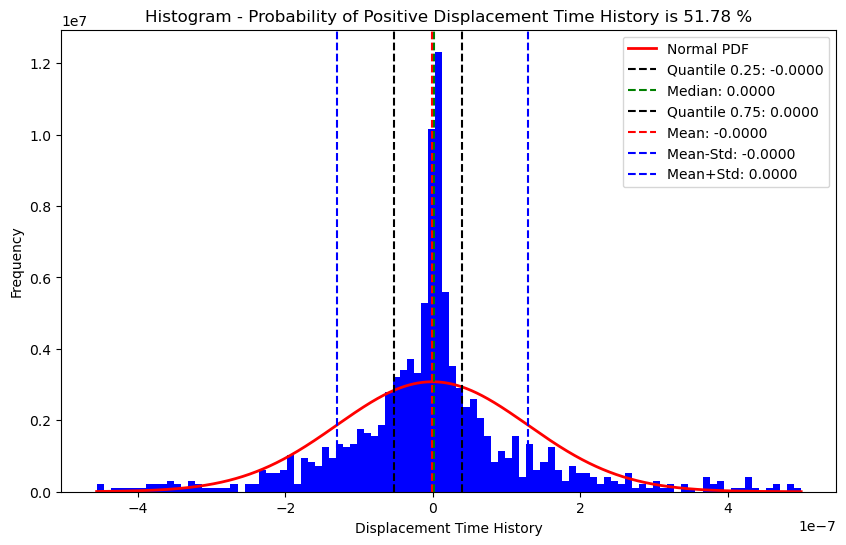

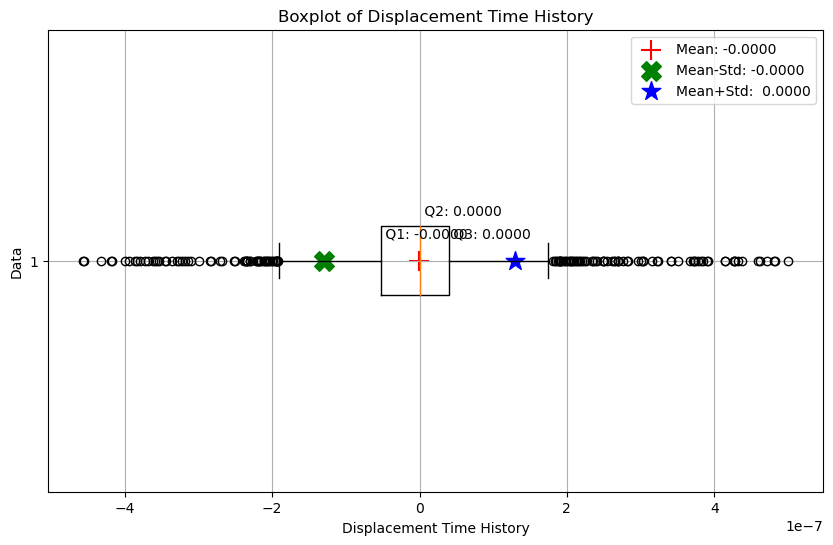

In [27]:
HISROGRAM_BOXPLOT(DTH, HISTO_COLOR='blue', LABEL='Displacement Time History')

-------------------------
Box-Chart Datas: 
Minimum: -0.0000
First quartile: -0.0000
Median: 0.0000
Mean: -0.0000
Std: 0.0000
Third quartile: 0.0000
Maximum: 0.0000
Skewness: -0.1868
kurtosis: 2.8380
90% Confidence Interval: (-0.0000, 0.0000)
-------------------------


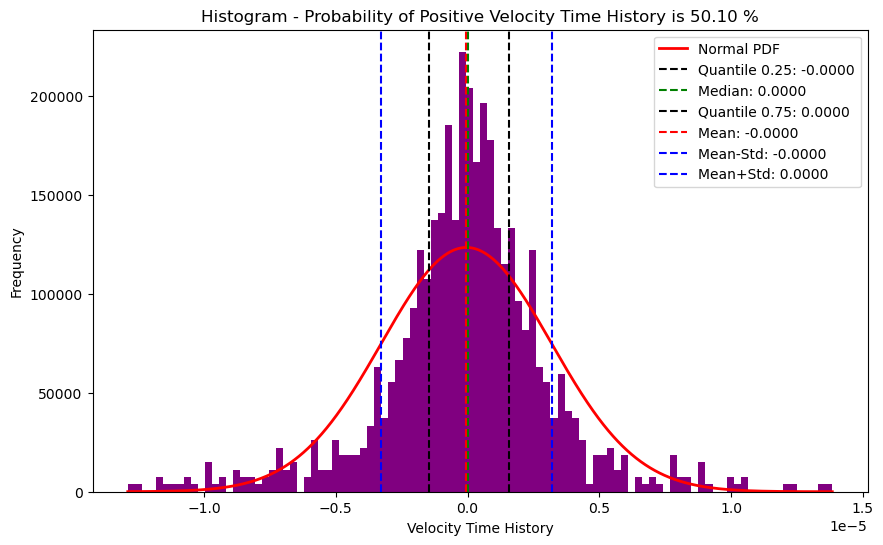

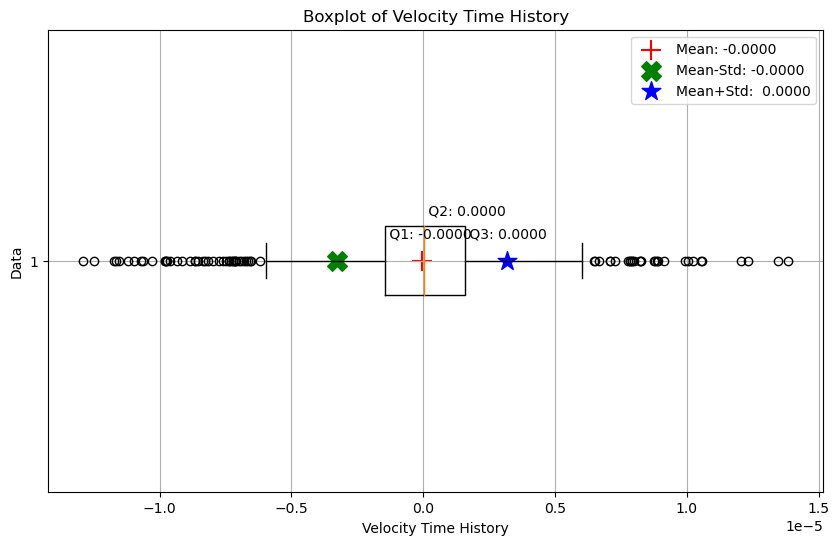

In [28]:
HISROGRAM_BOXPLOT(VTH, HISTO_COLOR='purple', LABEL='Velocity Time History')

-------------------------
Box-Chart Datas: 
Minimum: -0.0011
First quartile: -0.0001
Median: -0.0000
Mean: -0.0000
Std: 0.0002
Third quartile: 0.0001
Maximum: 0.0012
Skewness: 0.2476
kurtosis: 7.9938
90% Confidence Interval: (-0.0003, 0.0003)
-------------------------


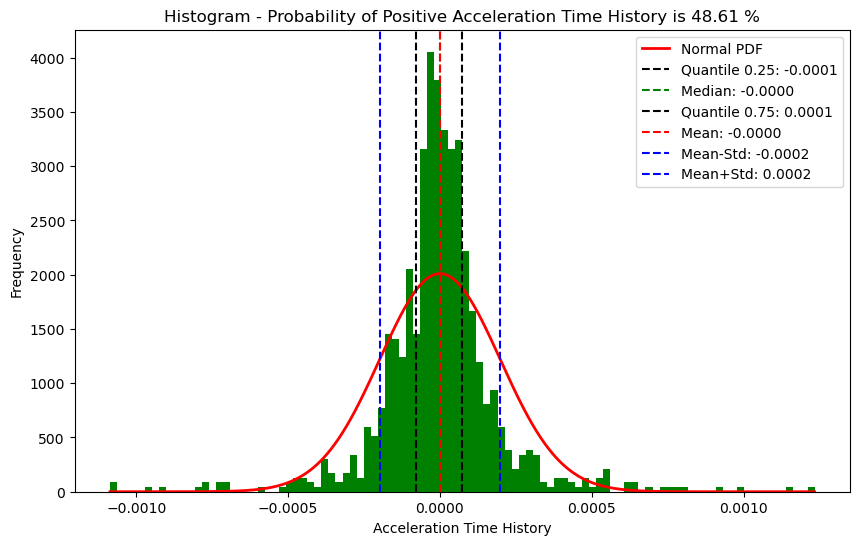

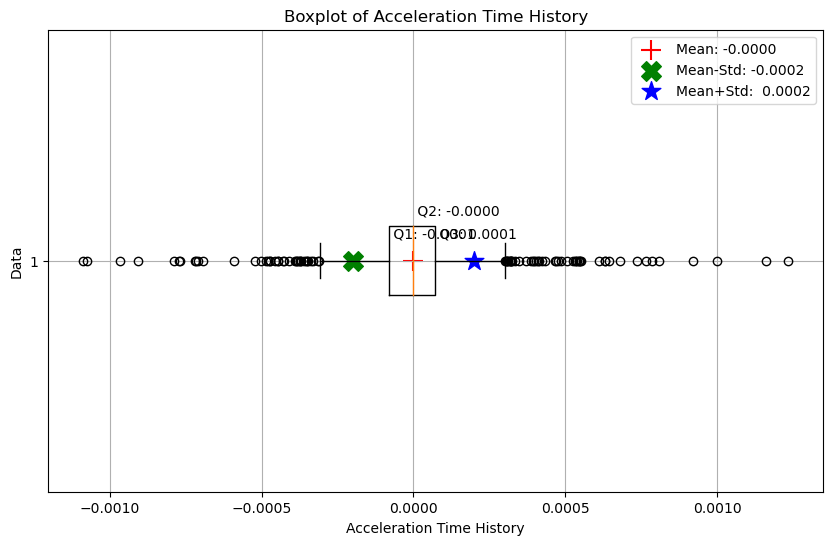

In [29]:
HISROGRAM_BOXPLOT(ATH, HISTO_COLOR='green', LABEL='Acceleration Time History')

-------------------------
Box-Chart Datas: 
Minimum: -0.4067
First quartile: -0.0324
Median: -0.0008
Mean: 0.0004
Std: 0.1054
Third quartile: 0.0427
Maximum: 0.3714
Skewness: -0.3153
kurtosis: 2.7682
90% Confidence Interval: (-0.1804, 0.1686)
-------------------------


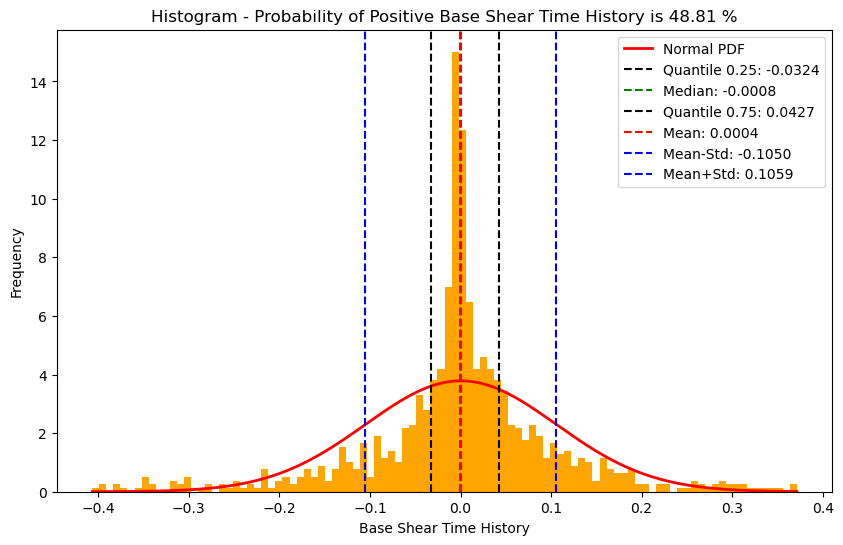

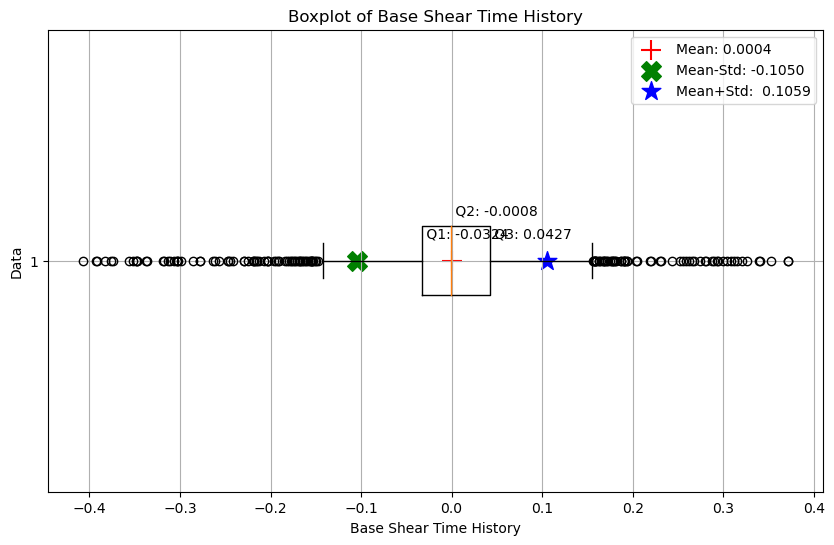

In [30]:
HISROGRAM_BOXPLOT(BTH, HISTO_COLOR='orange', LABEL='Base Shear Time History')

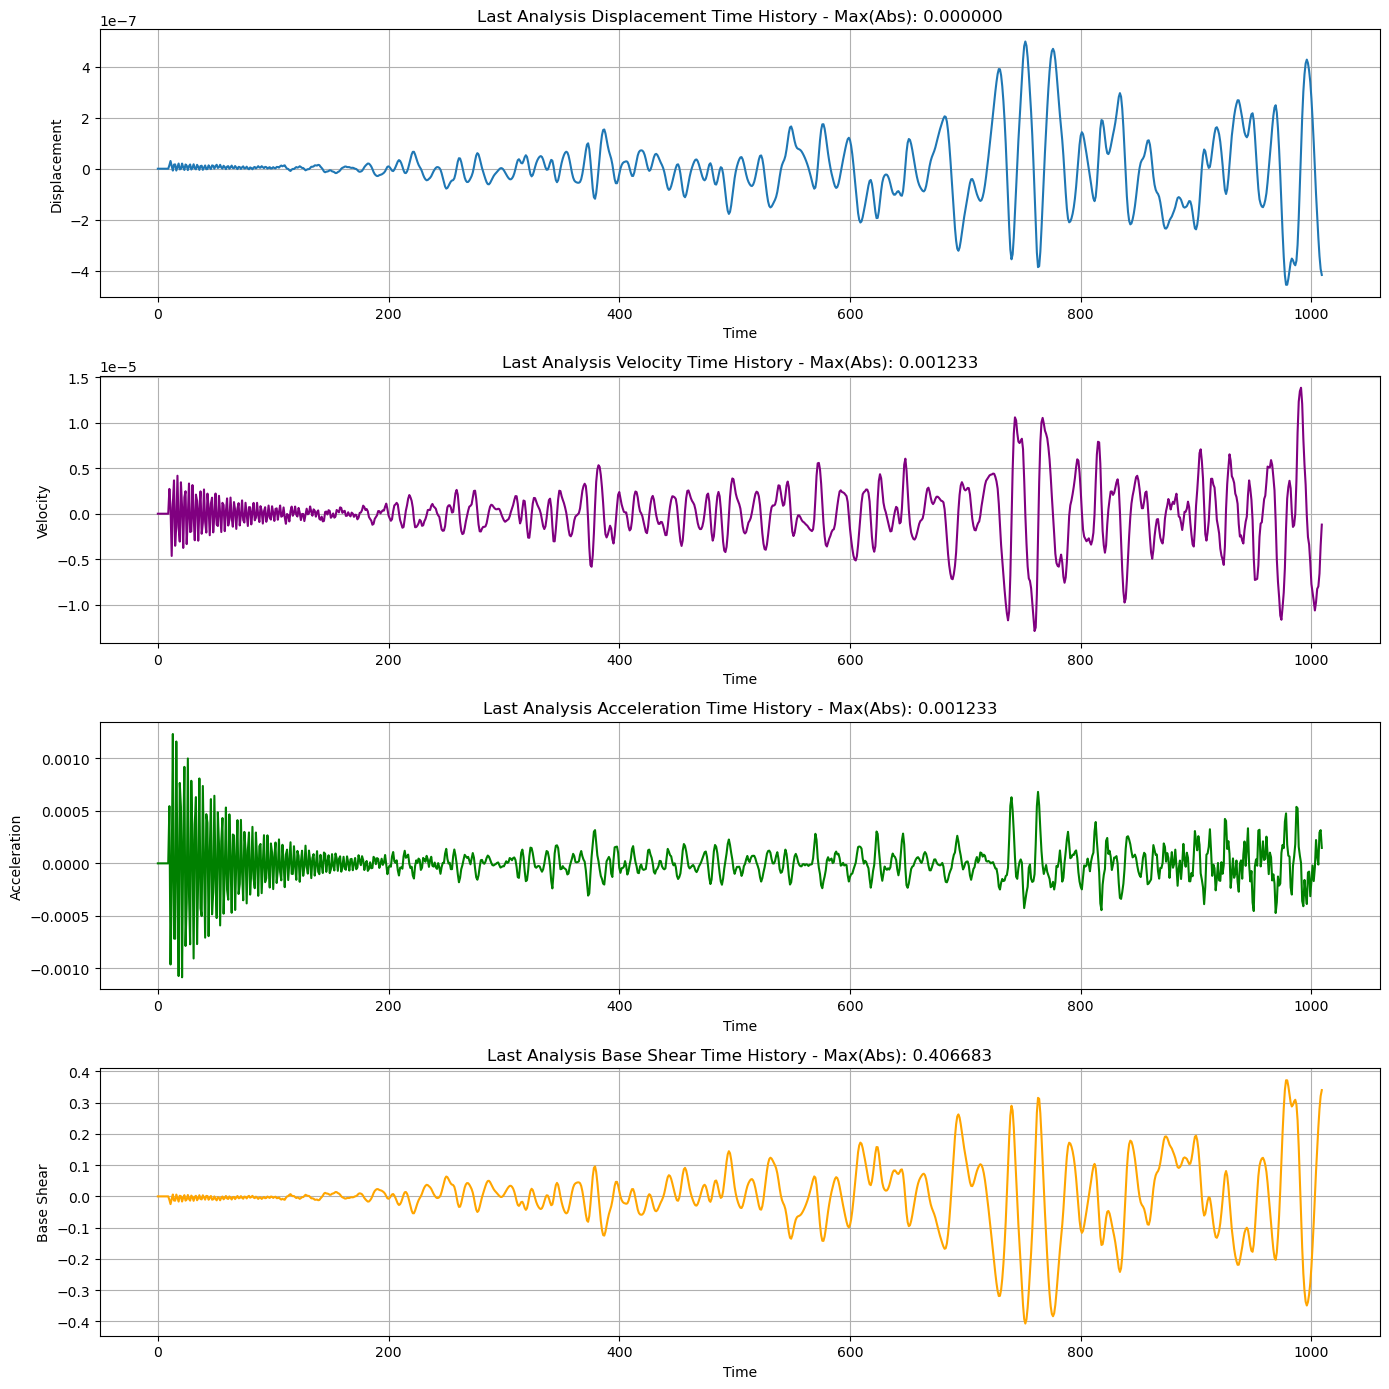

In [31]:
# PLOT TIME HISTORY 
PLOT_TIME_HIS(DTH, VTH, ATH, BTH)

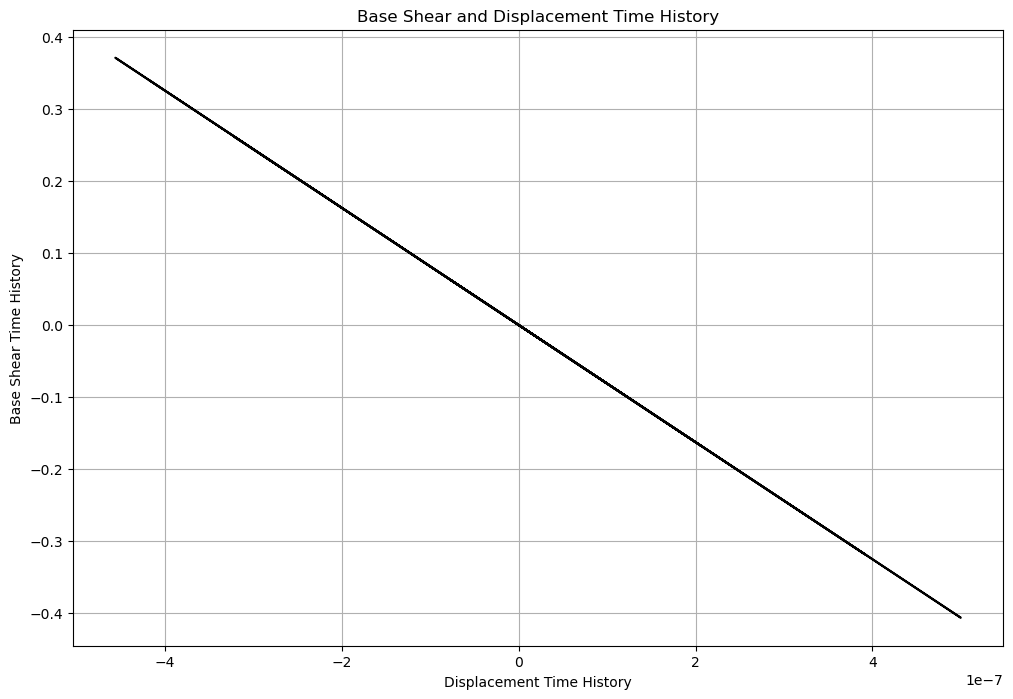

In [32]:
import numpy as np
import matplotlib.pyplot as plt


# Plot shear force and bending moment
plt.figure(figsize=(12, 8))
plt.plot(DTH, BTH,color='black')
plt.xlabel('Displacement Time History')
plt.ylabel('Base Shear Time History')
plt.title('Base Shear and Displacement Time History')
plt.grid()
plt.show()

In [ ]:
#  #########################################################################
#  #                           IN THE NAME OF ALLAH                        #
#  #    STEEL PLATE LENGTH OPTIMIZATION ANALYSIS WITH NONLINEAR DYNAMIC    #
#  #                         NEWTON-RAPHSON METHOD                         #
#  #-----------------------------------------------------------------------#
#  #              THIS PROGRAM WRITTEN BY SALAR DELAVAR QASHQAI            #
#  #                   EMAIL: salar.d.ghashghaei@gmail.com                 #
#  #########################################################################

In [16]:
### --------------------------------------------------------------
###          COMPOSITE SECTION COLUMN LENGTH OPTIMIZATION
### --------------------------------------------------------------

# define section geometry
LR = 100 # [mm] Retrofit Column length
TR = 5 # [mm] Retrofit Column Section Plate Thickness

LCol = 3000.0 # [mm] Column length
HCol = 300 # [mm] Column Depth
BCol = 300 # [mm] Column Width
coverCol = 50.0   # [mm] Column cover to reinforcing steel NA.
Weight = 10000.0 # [N] superstructure weight
numBarsCol = 4  # number of longitudinal-reinforcement bars in column. (symmetric top & bot)
BD = 20  # [mm] Rebar Diamater
fc = -25.0 # [N/mm^2] Concrete Compressive Strength (+Tension, -Compression)
X = LR # Intial Guess

ESP = 1e-3 # Finite difference derivative Convergence Tolerance
TOLERANCE = 1e-6 # Convergence Tolerance
RESIDUAL = 100 # Convergence Residual 
IT = 0 # Intial Iteration
ITMAX = 100000 # Max. Iteration
TARGET_PGD = 0.0000005 # [mm] Target Demand Max. Abs. Displacement Time History

DATA_FILE ='C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\MD02'  # MAX DISPLACEMENT
# monitor cpu time
import time
starttime = time.process_time()

### FIND THE OPTIMUM VALUE 
while (RESIDUAL > TOLERANCE):
    DYNAMIC_ANALYSIS(X, TR, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc)
    time.sleep(10);# Sleep for 10 seconds
    F = MAXABS_FUN(DATA_FILE) - TARGET_PGD
    print('Current Max. Abs. displacement: ', MAXABS_FUN(DATA_FILE))
    # Evaluate at Xmain and Fmin
    Xmin = X - ESP
    DYNAMIC_ANALYSIS(Xmin, TR, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc)
    time.sleep(10);# Sleep for 10 seconds
    Fmin = MAXABS_FUN(DATA_FILE) - TARGET_PGD
    # Evaluate at Xmax and Fmax
    Xmax = X + ESP
    DYNAMIC_ANALYSIS(Xmax, TR, HCol, BCol, LCol, coverCol, Weight, numBarsCol, BD, fc)
    time.sleep(10);# Sleep for 10 seconds
    Fmax = MAXABS_FUN(DATA_FILE) - TARGET_PGD
    # Calculate the Finite difference derivative of F
    DF = (Fmax-Fmin)/(2*ESP)
    # Calculate dx
    DX = F / DF
    # Calculate residual
    RESIDUAL = abs(DX)
    print('RESIDUAL: ', RESIDUAL)
    X -= DX # update X
    IT += 1 # update iteration
    if IT == ITMAX:
        print("\t\t Iteration reached to Max. Iteration")
        print("\t\t Change ESP and TOLERANCE for better Convergence")
        X = -1
        break;
    if RESIDUAL < TOLERANCE:
        print(f'\t\t Optimum Plate Length: {X:.4f}')
        print(f'\t\t Iteration Counts: {IT}')
        print(f'\t\t Convergence Residual {RESIDUAL:.10e}')
        
    #print(X)
    
totaltime = time.process_time() - starttime
print(f'\nTotal time (s): {totaltime:.4f} \n\n')

Ground Motion Done.
Current Max. Abs. displacement:  2.07448e-08
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  1198.1379999352125
Ground Motion Done.
Current Max. Abs. displacement:  3.08663e-06
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  517.3259999857199
Ground Motion Done.
Current Max. Abs. displacement:  1.17258e-06
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  134.51599999913537
Ground Motion Done.
Current Max. Abs. displacement:  8.15547e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  126.21880000186147
Ground Motion Done.
Current Max. Abs. displacement:  5.35417e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  17.70849999997995
Ground Motion Done.
Current Max. Abs. displacement:  5.00596e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  0.29799999999968235
Ground Motion Done.
Current Max. Abs. displacement:  5.00018e-07
Ground Motion Done.
Ground Motion Done.
RESIDUAL:  0.00900000000002647
Ground Motion Done.
Current Max. Abs. displacement:  5.

In [18]:
### LOAD DATAS
import numpy as np
import pandas as pd

# Displacement Time History
filename = f'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\DTH.txt'
data_collected = np.loadtxt(filename)
DTH = data_collected[:, 1]
# Velocity Time History
filename = 'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\VTH.txt'
data_collected = np.loadtxt(filename)
VTH = data_collected[:, 1]
# Acceleration Time History
filename = 'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\ATH.txt'
data_collected = np.loadtxt(filename)
ATH = data_collected[:, 1]
# Base Shear Time History
filename = 'C:\OPENSEESPY_SALAR\OPENSEESPY_DATA\BTH.txt'
data_collected = np.loadtxt(filename)
BTH = data_collected[:, 1]

print(len(DTH), len(VTH),len(ATH),len(BTH))

1010 1010 1010 1010


-------------------------
Box-Chart Datas: 
Minimum: -0.0000
First quartile: -0.0000
Median: 0.0000
Mean: -0.0000
Std: 0.0000
Third quartile: 0.0000
Maximum: 0.0000
Skewness: 0.3203
kurtosis: 2.7761
90% Confidence Interval: (-0.0000, 0.0000)
-------------------------


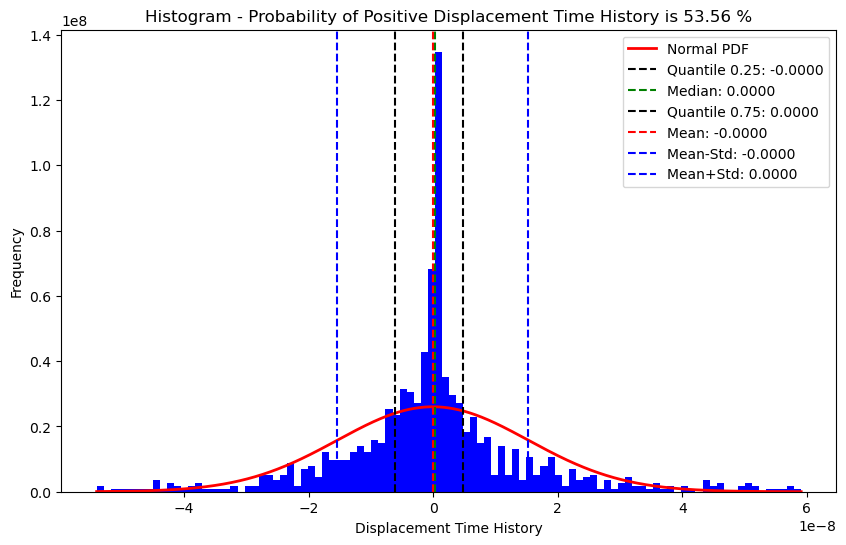

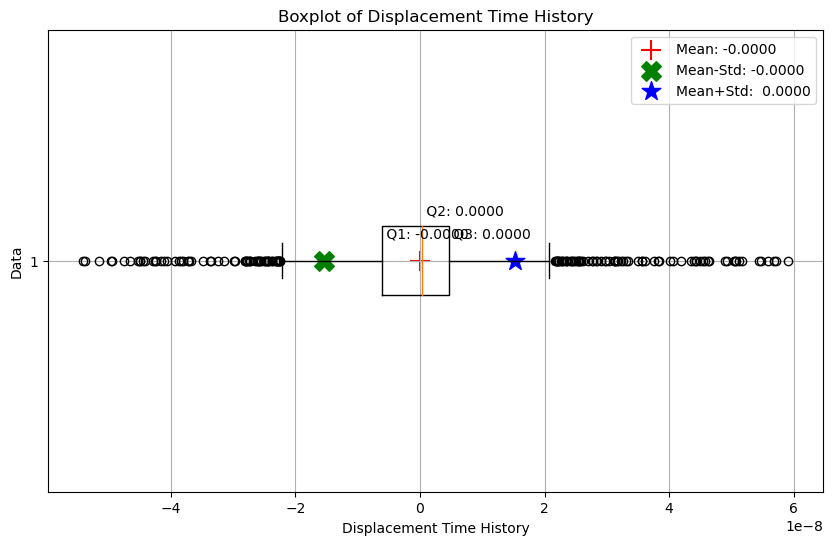

In [19]:
HISROGRAM_BOXPLOT(DTH, HISTO_COLOR='blue', LABEL='Displacement Time History')

-------------------------
Box-Chart Datas: 
Minimum: -0.0000
First quartile: -0.0000
Median: 0.0000
Mean: -0.0000
Std: 0.0000
Third quartile: 0.0000
Maximum: 0.0000
Skewness: -0.1866
kurtosis: 2.7999
90% Confidence Interval: (-0.0000, 0.0000)
-------------------------


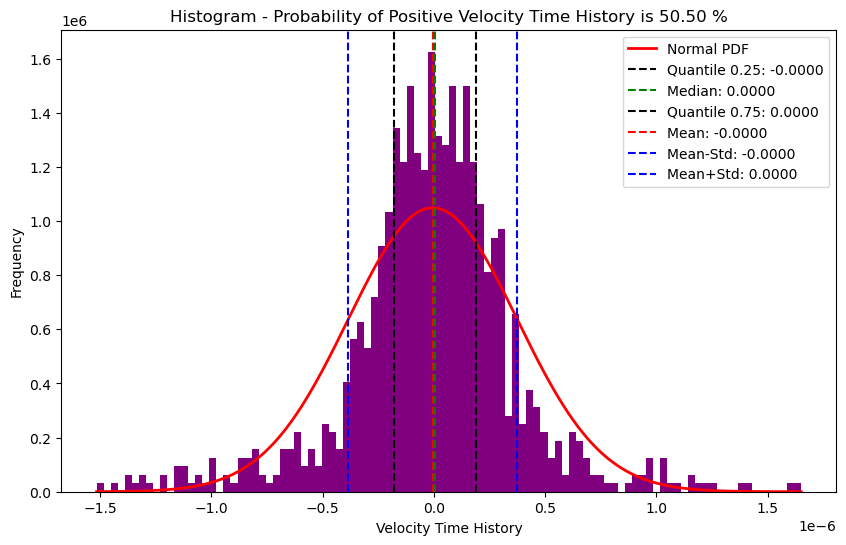

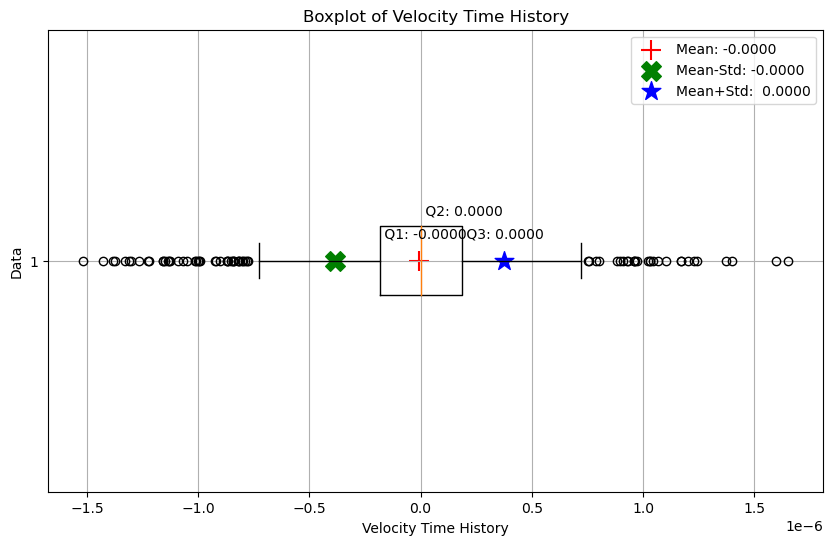

In [20]:
HISROGRAM_BOXPLOT(VTH, HISTO_COLOR='purple', LABEL='Velocity Time History')

-------------------------
Box-Chart Datas: 
Minimum: -0.0003
First quartile: -0.0000
Median: -0.0000
Mean: 0.0000
Std: 0.0001
Third quartile: 0.0000
Maximum: 0.0003
Skewness: 0.0191
kurtosis: 9.3514
90% Confidence Interval: (-0.0001, 0.0001)
-------------------------


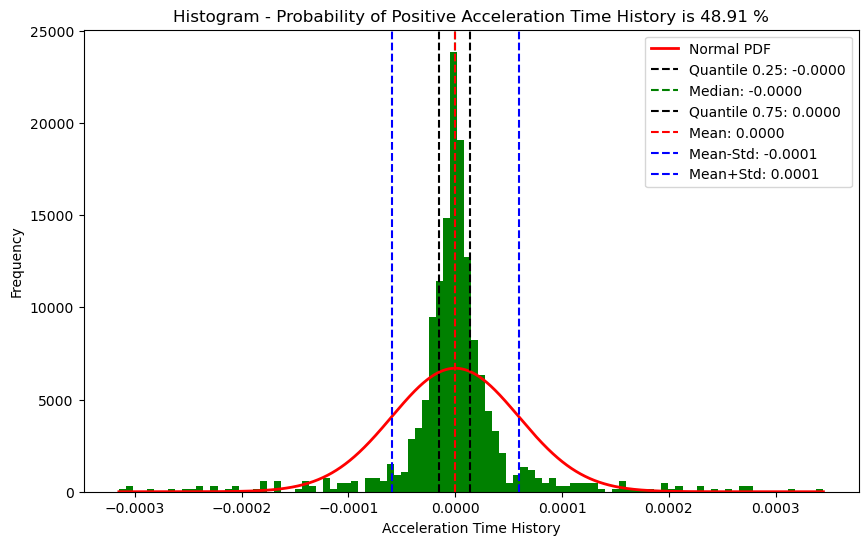

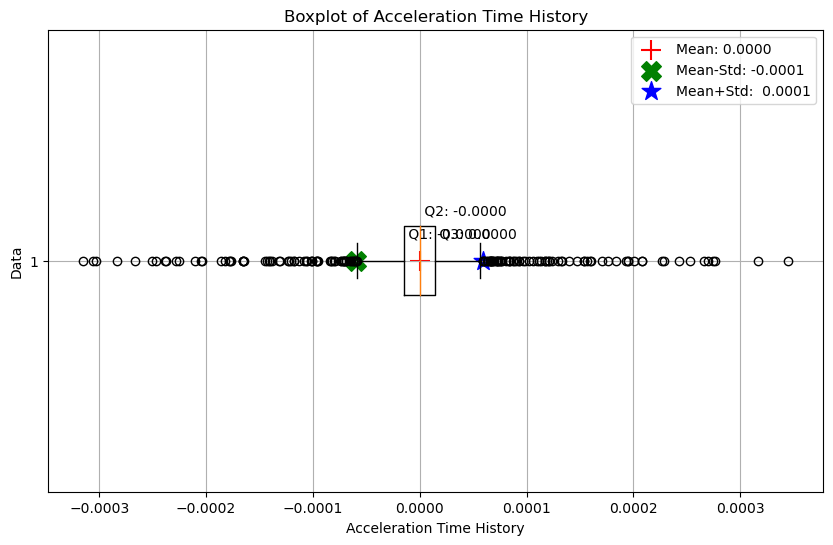

In [21]:
HISROGRAM_BOXPLOT(ATH, HISTO_COLOR='green', LABEL='Acceleration Time History')

-------------------------
Box-Chart Datas: 
Minimum: -0.0404
First quartile: -0.0032
Median: -0.0002
Mean: 0.0000
Std: 0.0105
Third quartile: 0.0042
Maximum: 0.0369
Skewness: -0.3201
kurtosis: 2.7760
90% Confidence Interval: (-0.0178, 0.0168)
-------------------------


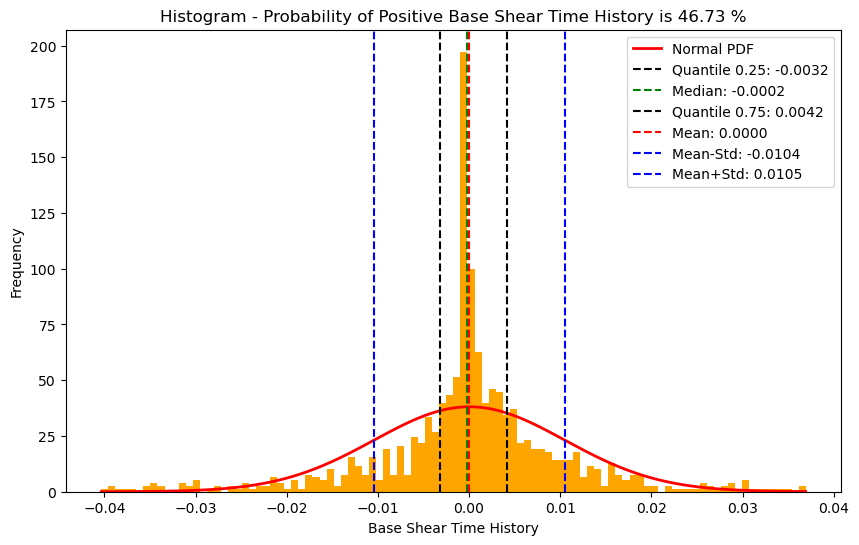

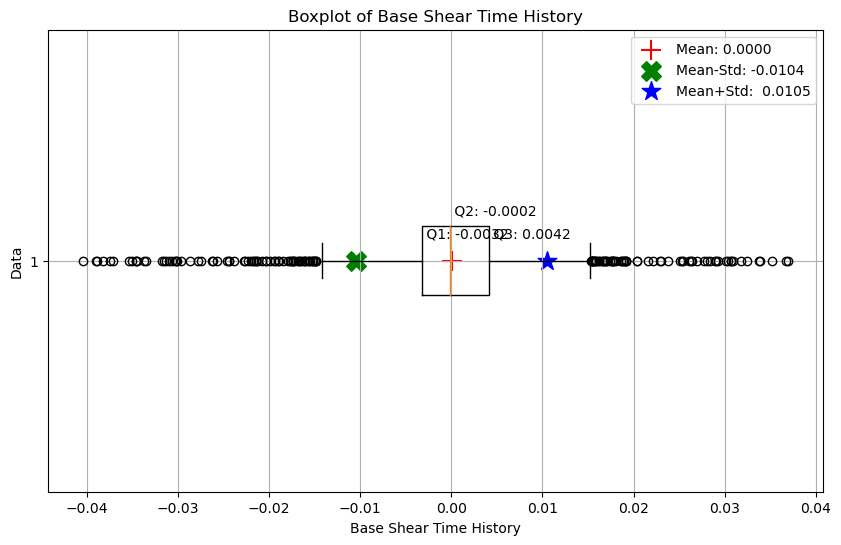

In [22]:
HISROGRAM_BOXPLOT(BTH, HISTO_COLOR='orange', LABEL='Base Shear Time History')

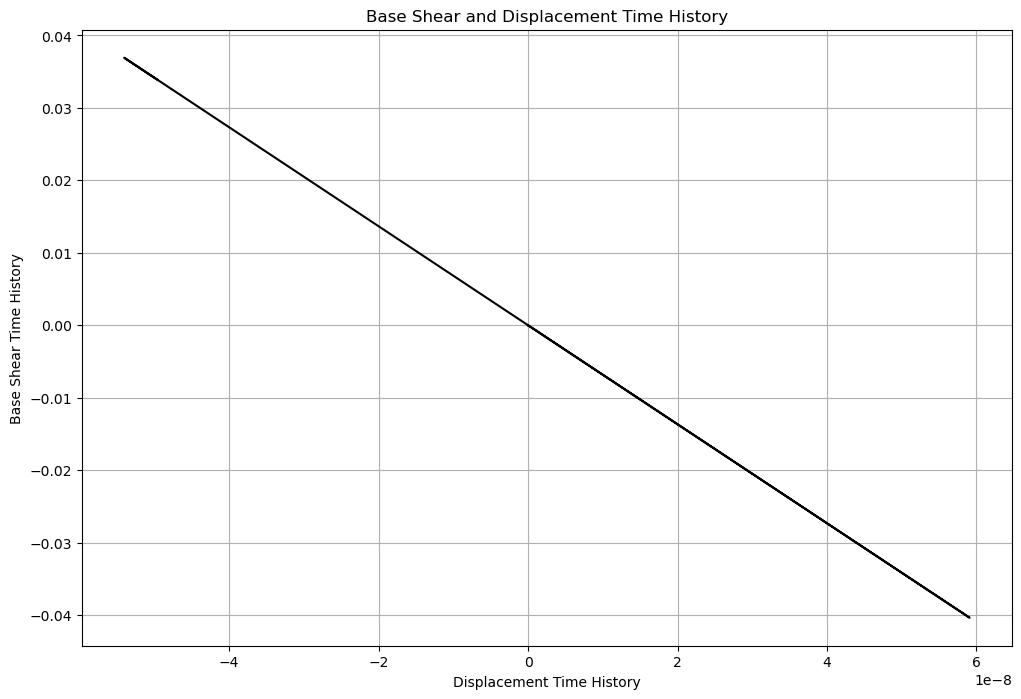

In [23]:
import numpy as np
import matplotlib.pyplot as plt


# Plot shear force and bending moment
plt.figure(figsize=(12, 8))
plt.plot(DTH, BTH,color='black')
plt.xlabel('Displacement Time History')
plt.ylabel('Base Shear Time History')
plt.title('Base Shear and Displacement Time History')
plt.grid()
plt.show()